In [ ]:
# import packages
import math, re, os, random, cv2
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras
from functools import partial
from sklearn.model_selection import train_test_split
print("Tensorflow version " + tf.__version__)

Tensorflow version 2.4.1


In [ ]:
# testing TPU
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

Number of replicas: 1


In [ ]:
# setting hyperparameters
AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 16 * strategy.num_replicas_in_sync
IMAGE_SIZE = [224, 224]
CLASSES = ['0', '1', '2', '3', '4']
EPOCHS = 100
LR = 0.0001

In [ ]:
# mount drive
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
path = "/content/drive/MyDrive/TensorFlow_Bros/Kaggle"

In [ ]:
# split data into training and validation data
training_filenames, valid_filenames = train_test_split(
    tf.io.gfile.glob(path + '/train_tfrecords/ld_train*.tfrec'),
    test_size=0.2, random_state=5
)

In [ ]:
# define functions to process TFRecords data using below website
# https://www.kaggle.com/jsmithperera/cassava-inference

def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.image.resize(image, IMAGE_SIZE)
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

def read_tfrecord(example, labeled):
    tfrecord_format = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.int64)
    } if labeled else {
        "image": tf.io.FixedLenFeature([], tf.string),
        "image_name": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    if labeled:
        label = tf.cast(example['target'], tf.int32)
        return image, label
    idnum = example['image_name']
    return image, idnum

def load_dataset(filenames, labeled=True, ordered=False):
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTOTUNE) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(partial(read_tfrecord, labeled=labeled), num_parallel_calls=AUTOTUNE)
    return dataset

def data_augment(image, label):
    image = tf.image.random_brightness(image, max_delta=0.5)
    image = tf.image.random_hue(image, 0.08)
    image = tf.image.random_saturation(image, 0.8, 1.2)
    image = tf.image.random_contrast(image, 0.8, 1.2)
    return image, label

In [ ]:
# functions to get training, validation, and testing data set
# https://www.kaggle.com/jsmithperera/cassava-inference

def get_test_dataset(ordered=False):
    dataset = load_dataset(TEST_FILENAMES, labeled=False, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTOTUNE)
    return dataset

def get_training_dataset():
    dataset = load_dataset(training_filenames, labeled=True)  
    dataset = dataset.map(data_augment, num_parallel_calls=AUTOTUNE)  
    dataset = dataset.repeat()
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTOTUNE)
    return dataset

def get_validation_dataset(ordered=False):
    dataset = load_dataset(valid_filenames, labeled=True, ordered=ordered) 
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.cache()
    dataset = dataset.prefetch(AUTOTUNE)
    return dataset

In [ ]:
def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

NUM_TRAINING_IMAGES = count_data_items(training_filenames)
NUM_VALIDATION_IMAGES = count_data_items(valid_filenames)

print('Dataset: {} training images, {} validation images'.format(
    NUM_TRAINING_IMAGES, NUM_VALIDATION_IMAGES))

Dataset: 16045 training images, 5352 validation images


In [ ]:
# import packages for model construction
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.models import load_model
from keras.callbacks import LearningRateScheduler
from keras.layers import Dense, Dropout, Input, MaxPooling2D, ZeroPadding2D, Conv2D, Flatten
from keras.models import Sequential, Model
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam, SGD
from keras.preprocessing.image import img_to_array, load_img, ImageDataGenerator
from keras.utils import to_categorical
from tensorflow.keras import regularizers
from tensorflow.keras.layers import MaxPool2D, AveragePooling2D, GlobalAveragePooling2D, GlobalMaxPooling2D
from tensorflow.keras.layers import Activation, BatchNormalization
from sklearn.model_selection import train_test_split

In [ ]:
# more data augmentation
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip(
      mode='horizontal_and_vertical'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(
      factor=(-0.125,0.125)),
])

In [ ]:
# early stopping condition
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10,
                                            restore_best_weights=True)

In [ ]:
# function to build model
def build_model():

  inputshape = (224, 224, 3) # input size
  inputs = tf.keras.Input(shape=inputshape)

  x = data_augmentation(inputs) # apply data augmentation

  base_model = ResNet50(weights = 'imagenet', include_top = False, 
                        input_shape=inputshape) # load base model
  
  # add layers to base model
  x = base_model(x)
  model = GlobalAveragePooling2D()(x)
  model = Dense(512,activation='relu',kernel_initializer='he_normal',kernel_regularizer=regularizers.l2(0.001))(model)
  model = BatchNormalization()(model)
  model = Dense(128,activation='relu',kernel_initializer='he_normal',kernel_regularizer=regularizers.l2(0.001))(model)
  model = BatchNormalization()(model)
  model = Dense(32,activation='relu',kernel_initializer='he_normal',kernel_regularizer=regularizers.l2(0.001))(model)
  model = BatchNormalization()(model)
  predictions = Dense(len(CLASSES), activation='softmax')(model)

  model = Model(inputs = inputs, outputs = predictions)
  return model

model = build_model()

94773248/94765736 [==============================] - 1s 0us/step


In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 224, 224, 3)       0         
_________________________________________________________________
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               1049088   
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2048      
_________________________________________________________________
dense_1 (Dense)              (None, 128)               65664 

In [ ]:
# compile model
model.compile(optimizer=Adam(learning_rate=LR), 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

In [ ]:
# set hyperparameters
STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE
VALID_STEPS = NUM_VALIDATION_IMAGES // BATCH_SIZE

In [ ]:
# get training and validation data
train_dataset = get_training_dataset()
valid_dataset = get_validation_dataset()

In [ ]:
# train model
history = model.fit(train_dataset,
                    steps_per_epoch=STEPS_PER_EPOCH,
                    epochs=EPOCHS,
                    validation_data=valid_dataset,
                    callbacks=[callback]
                    )

Epoch 1/100
1002/1002 [==============================] - 183s 136ms/step - loss: 2.6819 - accuracy: 0.5259 - val_loss: 2.2054 - val_accuracy: 0.7072
Epoch 2/100
1002/1002 [==============================] - 130s 130ms/step - loss: 2.0854 - accuracy: 0.7395 - val_loss: 1.9301 - val_accuracy: 0.7773
Epoch 3/100
1002/1002 [==============================] - 131s 130ms/step - loss: 1.9180 - accuracy: 0.7453 - val_loss: 1.9269 - val_accuracy: 0.7171
Epoch 4/100
1002/1002 [==============================] - 128s 127ms/step - loss: 1.7123 - accuracy: 0.7657 - val_loss: 1.5729 - val_accuracy: 0.7866
Epoch 5/100
1002/1002 [==============================] - 130s 130ms/step - loss: 1.5634 - accuracy: 0.7682 - val_loss: 1.4255 - val_accuracy: 0.7855
Epoch 6/100
1002/1002 [==============================] - 129s 129ms/step - loss: 1.3786 - accuracy: 0.7825 - val_loss: 1.3661 - val_accuracy: 0.7450
Epoch 7/100
1002/1002 [==============================] - 128s 128ms/step - loss: 1.2182 - accuracy: 0.7858

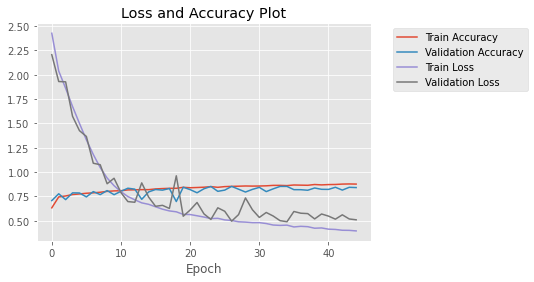

In [ ]:
# plot results
import matplotlib.pyplot as plt

N = 45
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history.history["accuracy"], label="Train Accuracy")
plt.plot(np.arange(0, N), history.history["val_accuracy"], label="Validation Accuracy")
plt.plot(np.arange(0, N), history.history["loss"], label="Train Loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="Validation Loss")
plt.title("Loss and Accuracy Plot")
plt.xlabel("Epoch")
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.savefig("midterm_plot.png")

In [ ]:
# save model
# https://colab.research.google.com/github/tensorflow/examples/blob/master/courses/udacity_intro_to_tensorflow_for_deep_learning/l07c01_saving_and_loading_models.ipynb#scrollTo=OGNpmn43C0O6

import time
t = time.time()

export_path_keras = "./{}.h5".format(int(t))
print(export_path_keras)

model.save(export_path_keras)

export_path_sm = "./{}".format(int(t))
print(export_path_sm)

tf.saved_model.save(model, export_path_sm)

./1616279558.h5
./1616279558
INFO:tensorflow:Assets written to: ./1616279558/assets


In [ ]:
# download model to computer

!zip -r model.zip {export_path_sm}

try:
  from google.colab import files
  files.download('./model.zip')
except ImportError:
  pass

updating: 1616279558/ (stored 0%)
updating: 1616279558/variables/ (stored 0%)
updating: 1616279558/variables/variables.data-00000-of-00001 (deflated 7%)
updating: 1616279558/variables/variables.index (deflated 80%)
updating: 1616279558/assets/ (stored 0%)
updating: 1616279558/saved_model.pb (deflated 92%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>